In [1]:
import sys
sys.path.insert(0, '../')
from lib import *

%matplotlib inline

def gauss(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))



In [2]:
SAMPLING=4e-9
BITS= 16384
DYNAMIC_RANGE= 2
AMP= np.array([250,250,250,250,1030])
e_charge=1.60217663 * 1e-19

#                           ADCs to V     ticks to sec          C to e-      still need to correct by Gain of specific run
ADCxTicks2e=       DYNAMIC_RANGE/BITS     * SAMPLING  / AMP  /e_charge

## Multiple runs

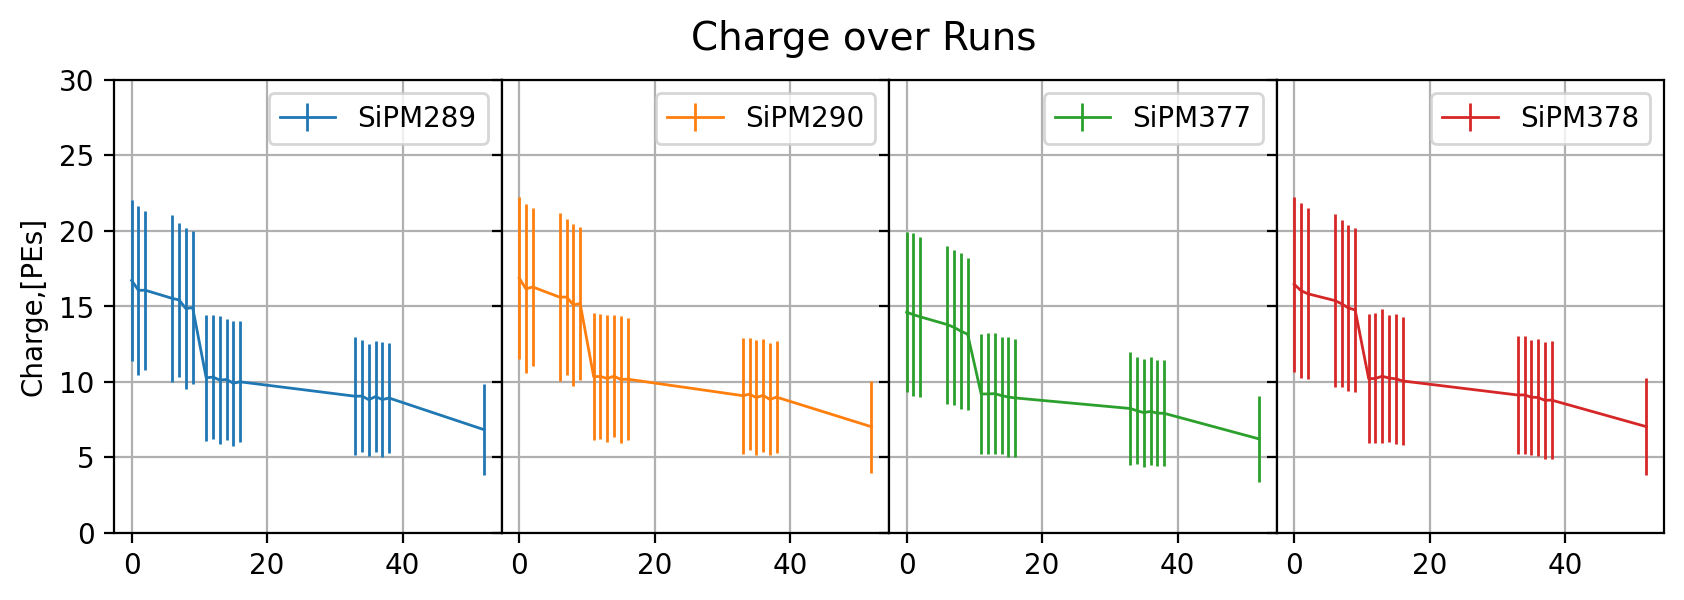

<Figure size 432x288 with 0 Axes>

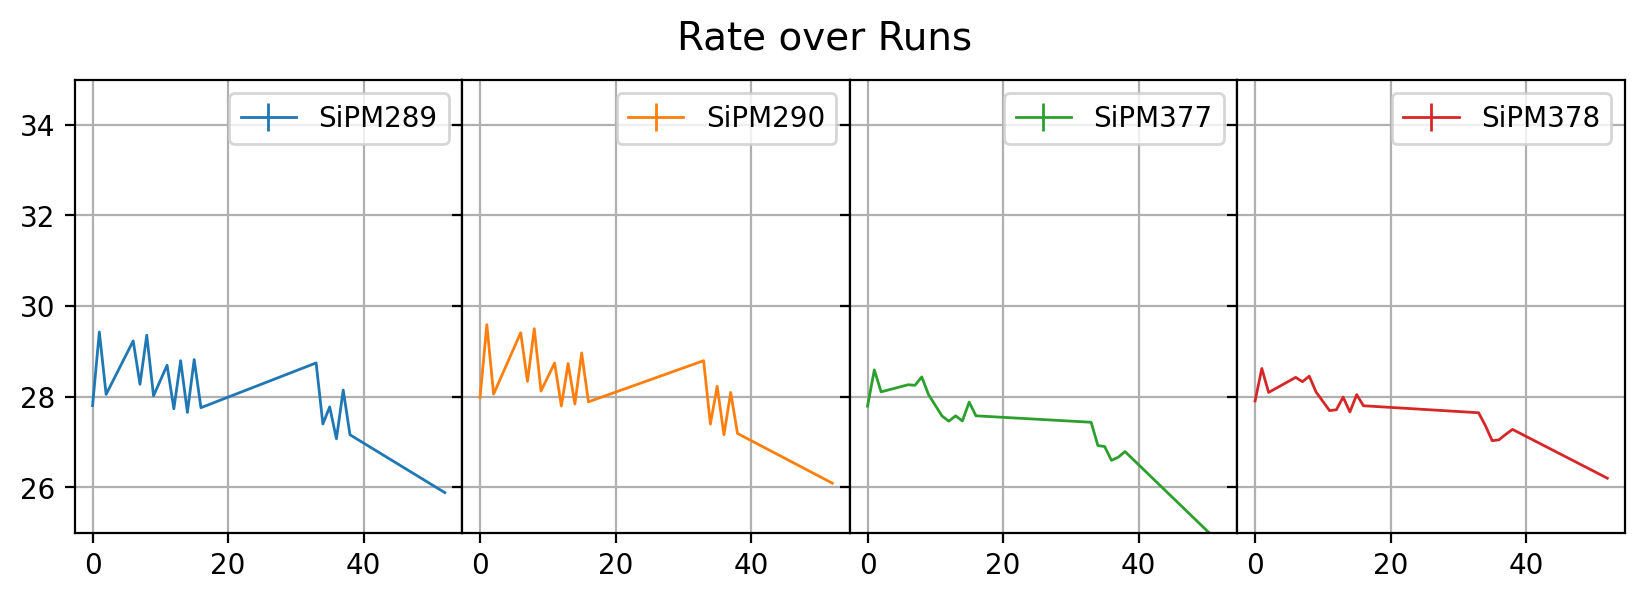

In [16]:
# path="/media/rodrigoa/DiscoDuro/SBND_XA_PDE/APSAIA_VIS/joython/"
# Run_props=open_run_properties(0,"../macros/APSAIA_VIS.xlsx")
# Runs=open_runs_table("../macros/APSAIA_VIS.xlsx")
# GAIN=np.array([6.48E+06,	6.72E+06,	6.68E+06,	6.67E+06,	3.00E+06]) #from calibrations, AT 4/2.5v

WEEK="APSAIA_VUV";
path="/scr/neutrinos/rodrigoa/"+WEEK+"/joython/"
Runs=open_runs_table("../macros/"+WEEK+".xlsx")

GAIN=np.array([6.36E+06,	6.61E+06,	6.66E+06,	6.63E+06,	3.00E+06]) #from calibrations, AT 4/2.5v
ADCxTicks2PE=ADCxTicks2e/GAIN

Runs=Runs[Runs["Type"]=="Alfa"]

amp  =np.zeros((len(Runs["Channels"].iloc[0]),Runs["Run"].array.shape[0]))
mean =np.zeros((len(Runs["Channels"].iloc[0]),Runs["Run"].array.shape[0]))
err  =np.zeros((len(Runs["Channels"].iloc[0]),Runs["Run"].array.shape[0]))
rate =np.zeros((len(Runs["Channels"].iloc[0]),Runs["Run"].array.shape[0]))

i=0

for ch in Runs["Channels"].iloc[0][:-1]:
# for ch in [0]:
    r=0;
    for run in Runs["Run"].array:
    # for run in [0]:
        
        Run_props=Runs[Runs["Run"]==run].iloc[0]
        run_path=path+"run"+str(run).zfill(2)+"/";
        compress=False
        Pedestal_vars=open_run_var(run_path,"Pedestal_vars",[ch],compressed=compress)
        Charge_vars  =open_run_var(run_path ,"Charge_vars" ,[ch],compressed=compress)
        Peak_vars    =open_run_var(run_path ,"Peak_vars"   ,[ch],compressed=compress)
        TS=open_run_var(run_path,"Timestamp",[ch],compressed=compress)

        Ped_CUT=Pedestal_vars[ch]["STD"]<10
        counts,bins=np.histogram(Charge_vars[ch]["PeakFinderInRange"][Ped_CUT*Peak_vars[ch]["Peak"]>50],100,[0,3e4]);

        std=np.std(Charge_vars[ch]["PeakFinderInRange"][Ped_CUT*Peak_vars[ch]["Peak"]>50])

        popt, pcov = curve_fit(gauss, bins[1:], counts,p0=[max(counts),bins[np.argmax(counts)],std])
        
        
        ym = gauss(bins[1:], popt[0], popt[1], popt[2])
        # plt.plot  (bins[1:], ym, c='r', label='Best fit')
        amp [i,r]=popt[0]
        mean[i,r]=popt[1]*ADCxTicks2PE[i]
        err [i,r]=popt[2]*ADCxTicks2PE[i]
        
        duration=(TS[ch][-1]-TS[ch][0])
        rate[i,r]=np.sqrt(np.pi*2*popt[2]**2)*popt[0]*100/3e4/duration #gauss integral divided by bin tickness
        r+=1;
    i+=1;

x=Runs["Run"].array
ys=mean[:4]
yer=err[:4]
legend=Run_props["ChannelName"][:4]

fig,axs=horizontal_subplots(x,ys,yer,legend)
plt.suptitle("Charge over Runs", fontsize=14)
axs[0].set_ylabel("Charge,[PEs]")
for ax in axs: ax.set_ylim([0,30])

plt.figure()
ys=rate[:4]
yer=np.zeros(ys.shape)
fig,axs=horizontal_subplots(x,rate[:4],yer,legend)
plt.suptitle("Rate over Runs", fontsize=14)
for ax in axs: ax.set_ylim([25,35])



## Single Run

(1, 2000.0)

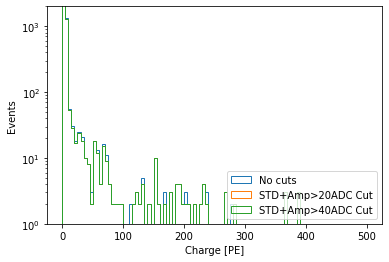

In [41]:
# Let's create a function to model and create data
WEEK="APSAIA_VIS";
path="/scr/neutrinos/rodrigoa/"+WEEK+"/joython/"

for ch in [5]:
    r=0;
    # for run in Runs["Run"].array:
    for run in [0]:
        Run_props=open_run_properties(run,"../macros/APSAIA_VIS.xlsx")
        run_path=path+"run"+str(run).zfill(2)+"/";
        compress=False
        Pedestal_vars=open_run_var(run_path,"Pedestal_vars",[ch],compressed=compress)
        Charge_vars  =open_run_var(run_path ,"Charge_vars" ,[ch],compressed=compress)
        Peak_vars    =open_run_var(run_path ,"Peak_vars"   ,[ch],compressed=compress)


Ped_CUT=Pedestal_vars[ch]["STD"]<10

plt.hist(Charge_vars[ch]["PeakFinderInRange"]                                                 *ADCxTicks2PE[4],100,[0,500],histtype="step");
plt.hist(Charge_vars[ch]["PeakFinderInRange"][Ped_CUT*Peak_vars[ch]["Peak"]>20]               *ADCxTicks2PE[4],100,[0,500],histtype="step");
plt.hist(Charge_vars[ch]["PeakFinderInRange"][Ped_CUT*Peak_vars[ch]["Peak"]>40]               *ADCxTicks2PE[4],100,[0,500],histtype="step");
# counts,bins=np.histogram(Charge_vars[0]["PeakFinderInRange"][Ped_CUT*Peak_vars[ch]["Peak"]>40]*ADCxTicks2PE[4],100,[0,30]);

# std=np.std(Charge_vars[0]["PeakFinderInRange"][Ped_CUT*Peak_vars[ch]["Peak"]>40]*ADCxTicks2PE[4])

# popt, pcov = curve_fit(gauss, bins[1:], counts,p0=[max(counts),bins[np.argmax(counts)],std])


# print(sum(gauss(np.arange(0,1e8),popt[0], popt[1], popt[2])) ) 

# ym = gauss(bins[1:], popt[0], popt[1], popt[2])
# plt.plot  (bins[1:], ym, c='r', label='Best fit')

plt.semilogy()

plt.legend(["No cuts","STD+Amp>20ADC Cut","STD+Amp>40ADC Cut","Best Fit"],loc="lower right")
plt.xlabel("Charge [PE]")
plt.ylabel("Events")
plt.ylim([1,2e3])


## Multiple Runs: amplitude

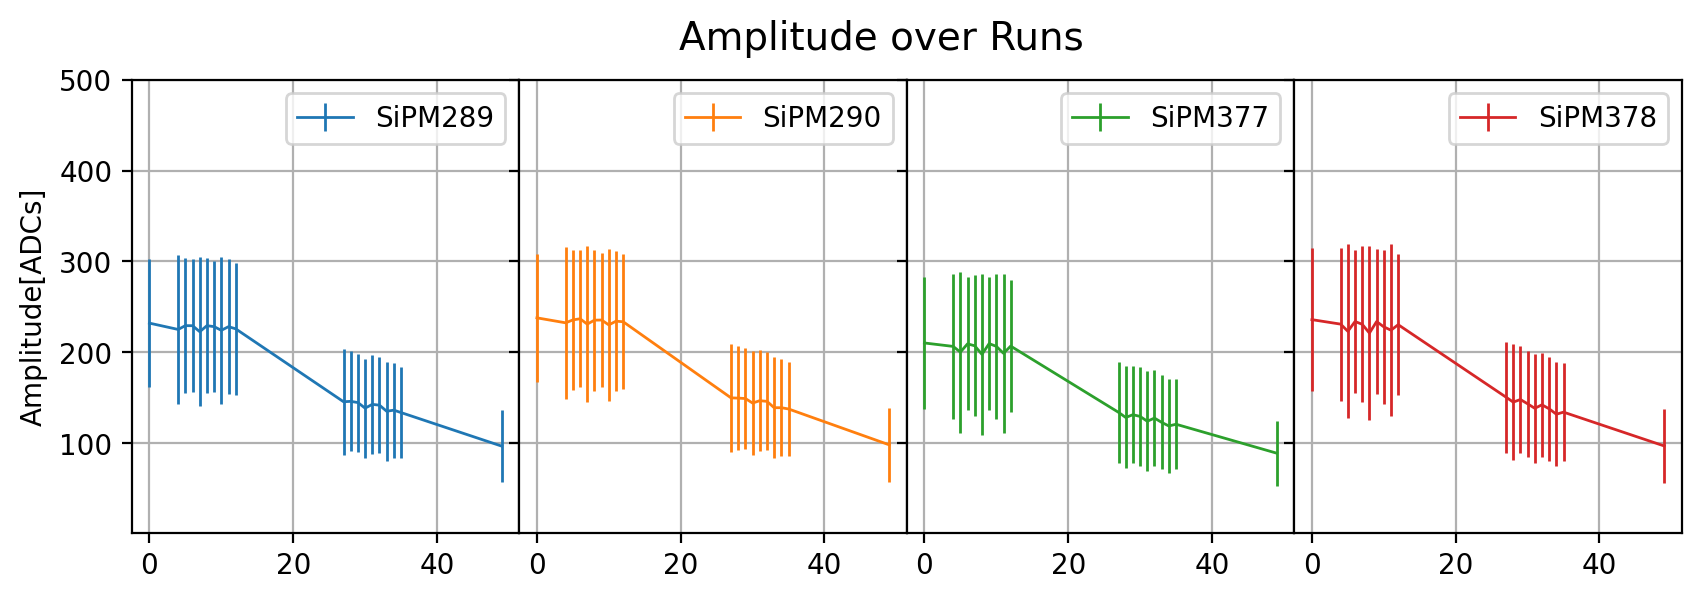

In [22]:
Runs=Runs[Runs["Type"]=="Alfa"]


amp  =np.zeros((len(Run_props["Channels"]),Runs["Run"].array.shape[0]))
mean =np.zeros((len(Run_props["Channels"]),Runs["Run"].array.shape[0]))
err  =np.zeros((len(Run_props["Channels"]),Runs["Run"].array.shape[0]))
rate =np.zeros((len(Run_props["Channels"]),Runs["Run"].array.shape[0]))

i=0

for ch in Run_props["Channels"]:
# for ch in [0]:
    r=0;
    for run in Runs["Run"].array:
    # for run in [0]:
        
        Run_props=open_run_properties(run,"../macros/APSAIA_VUV.xlsx")
        run_path=path+"run"+str(run).zfill(2)+"/";
        compress=False
        Pedestal_vars=open_run_var(run_path,"Pedestal_vars",[ch],compressed=compress)
        Charge_vars  =open_run_var(run_path ,"Charge_vars" ,[ch],compressed=compress)
        Peak_vars    =open_run_var(run_path ,"Peak_vars"   ,[ch],compressed=compress)
        TS=open_run_var(run_path,"Timestamp",[ch],compressed=compress)

        Ped_CUT=Pedestal_vars[ch]["STD"]<10
        counts,bins=np.histogram(Peak_vars[ch]["Peak"][Ped_CUT*Peak_vars[ch]["Peak"]>40],100,[0,1000]);
        
        # plt.hist(Peak_vars[ch]["Peak"][Ped_CUT*Peak_vars[ch]["Peak"]>40],100,[0,1000]);

        std=np.std(Peak_vars[ch]["Peak"][Ped_CUT*Peak_vars[ch]["Peak"]>40])

        try: 
            popt, pcov = curve_fit(gauss, bins[1:], counts,p0=[max(counts),bins[np.argmax(counts)],std])
            amp [i,r]=popt[0]
            mean[i,r]=popt[1]
            err [i,r]=popt[2]
        except:
            amp [i,r]=0
            mean[i,r]=0
            err [i,r]=0

        
        r+=1;
    i+=1;


x=Runs["Run"].array
ys=mean[:4]
yer=err[:4]
legend=Run_props["ChannelName"][:4]

fig,axs=horizontal_subplots(x,ys,yer,legend)
plt.suptitle("Amplitude over Runs", fontsize=14)
axs[0].set_ylabel("Amplitude[ADCs]")
for ax in axs: ax.set_ylim([2,500])

## Single Run, Amplitude

168622.8808309386


(1.0, 1000.0)

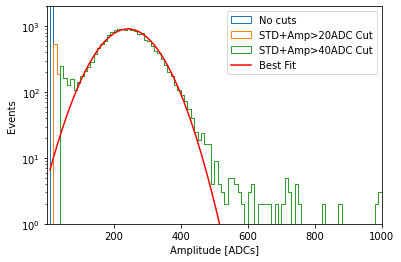

In [38]:
# Let's create a function to model and create data

for ch in [0]:
    r=0;
    # for run in Runs["Run"].array:
    for run in [0]:
        Run_props=open_run_properties(run,"../macros/APSAIA_VUV.xlsx")
        run_path=path+"run"+str(run).zfill(2)+"/";
        compress=False
        Pedestal_vars=open_run_var(run_path,"Pedestal_vars",[ch],compressed=compress)
        Charge_vars  =open_run_var(run_path ,"Charge_vars" ,[ch],compressed=compress)
        Peak_vars    =open_run_var(run_path ,"Peak_vars"   ,[ch],compressed=compress)


Ped_CUT=Pedestal_vars[0]["STD"]<6

plt.hist(Peak_vars[0]["Peak"]                                 ,100,[0,1e3],histtype="step");
plt.hist(Peak_vars[0]["Peak"][Ped_CUT*Peak_vars[0]["Peak"]>20],100,[0,1e3],histtype="step");
plt.hist(Peak_vars[0]["Peak"][Ped_CUT*Peak_vars[0]["Peak"]>40],100,[0,1e3],histtype="step");
counts,bins=np.histogram(Peak_vars[0]["Peak"][Ped_CUT*Peak_vars[0]["Peak"]>40],100,[0,1e3]);

std=np.std(Peak_vars[0]["Peak"][Ped_CUT*Peak_vars[0]["Peak"]>40])

popt, pcov = curve_fit(gauss, bins[1:], counts,p0=[max(counts),bins[np.argmax(counts)],std])


print(sum(gauss(np.arange(0,1e8),popt[0], popt[1], popt[2])) ) 

ym = gauss(bins[1:], popt[0], popt[1], popt[2])
plt.plot  (bins[1:], ym, c='r', label='Best fit')

plt.semilogy()

plt.legend(["No cuts","STD+Amp>20ADC Cut","STD+Amp>40ADC Cut","Best Fit"])
plt.xlabel("Amplitude [ADCs]")
plt.ylabel("Events")
plt.ylim([1,2e3])
plt.xlim([1,1e3])
